**Exercise 1.** Change our model to use a 5x5 kernel with `kernel_size=5` passed to the `nn.Conv2d` constructor.

a. What impact does this change have on the number of parameters in the model?

b. Does the change improve or degrade overfitting?

c. Read https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html.

d. Can you describe what `kernel_size=(1, 3)` will do?

e. How does the model behave with such a kernel?

**Note:** It's not clear (in the above text) which specific model "*our model*" is referring to. In the book, several models are trained: `Net`, `NetWidth`, `NetWidth` with L2 regularization, `NetDropout`, `NetBatchNorm`, `NetDepth`, `NetRes` and `NetResDeep`.

Hence, for this exercise, we will answer the above questions using `Net` (the baseline CNN).

# Setup

In [1]:
!pip install -q datasets evaluate

In [2]:
!pip install -q wandb

If running this notebook in Colab, please ensure that your Hugging Face `HF_TOKEN` and your Weights & Biases `WANDB_API_KEY` are added to your Colab secrets.

Alternatively, please login to Hugging Face and Weights & Biases by running the following two cells.

In [3]:
# !huggingface-cli login

In [4]:
# !wandb login

In [5]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Data Prep

In [6]:
from datasets import load_dataset

cifar10 = load_dataset("cifar10")
cifar10

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [7]:
features = cifar10['train'].features
features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [8]:
id2label = {id: label for id, label in enumerate(features['label'].names)}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [9]:
example = cifar10['train'][0]
example

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

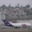

In [10]:
example['img']

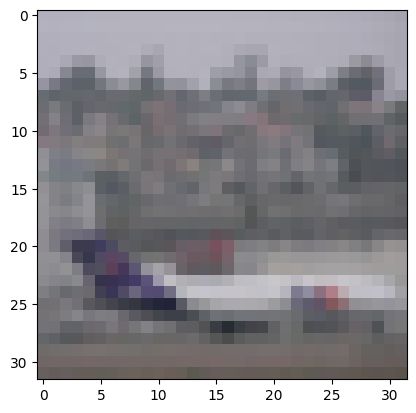

In [11]:
import matplotlib.pyplot as plt

plt.imshow(example['img']);

In [12]:
example['label']

0

In [13]:
id2label[example['label']]

'airplane'

Let's create a PyTorch `Dataset` for model training.

In [14]:
from torch.utils.data import Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, tfms):
        self.dataset = dataset
        self.tfms = tfms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        img, label = example['img'], example['label']
        img = self.tfms(img)
        return img, label

**Note:** There is no need to convert `label` to a tensor as the data collator will collate the integers into a tensor anyway.

In [15]:
from torchvision.transforms import v2

tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616])
])

**Note:** `ToImage()` along with `ToDtype(torch.float32, scale=True)` is a replacement for `ToTensor()` in `torchvision.transforms.v2`.

In [16]:
cifar10_train = CIFAR10Dataset(cifar10['train'], tfms)
len(cifar10_train)

50000

In [17]:
# Sanity check:
img, label = cifar10_train[0]
img.shape, label

(torch.Size([3, 32, 32]), 0)

In [18]:
cifar10_val = CIFAR10Dataset(cifar10['test'], tfms)
len(cifar10_val)

10000

In [19]:
# Sanity check:
img, label = cifar10_val[0]
img.shape, label

(torch.Size([3, 32, 32]), 3)

In [20]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

In [21]:
cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in [0, 2]]
len(cifar2_train)

10000

In [22]:
# Sanity check:
img, label = cifar2_train[0]
img.shape, label

(torch.Size([3, 32, 32]), 0)

In [23]:
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]
len(cifar2_val)

2000

In [24]:
# Sanity check:
img, label = cifar2_val[0]
img.shape, label

(torch.Size([3, 32, 32]), 0)

In [25]:
from torch.utils.data import DataLoader

batch_size = 64
train_dl = DataLoader(cifar2_train, batch_size=batch_size, shuffle=True, num_workers=2)
len(train_dl)

157

In [26]:
# Sanity check:
imgs, labels = next(iter(train_dl))
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [27]:
imgs.dtype, labels.dtype

(torch.float32, torch.int64)

In [28]:
val_dl = DataLoader(cifar2_val, batch_size=batch_size, shuffle=False, num_workers=2)
len(val_dl)

32

In [29]:
# Sanity check:
imgs, labels = next(iter(val_dl))
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [30]:
imgs.dtype, labels.dtype

(torch.float32, torch.int64)

# Net

In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

First, let's re-create and train `Net` from the book.

In [32]:
import torch.nn as nn
import torch.nn.functional as F
from huggingface_hub import PyTorchModelHubMixin

class Net(nn.Module, PyTorchModelHubMixin):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1, stride=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2, stride=2) # Output shape: (batch_size, 16, 16, 16)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), kernel_size=2, stride=2) # Output shape: (batch_size, 8, 8, 8)
        out = out.view(-1, 8 * 8 * 8) # Output shape: (batch_size, 512)
        out = torch.tanh(self.fc1(out)) # Output shape: (batch_size, 32)
        out = self.fc2(out) # Output shape: (batch_size, 2)
        return out

In [33]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [34]:
# Sanity check:
imgs = imgs.to(device)
with torch.no_grad():
    logits = model(imgs)
logits.shape

torch.Size([64, 2])

In [35]:
loss_fn = nn.CrossEntropyLoss()

In [36]:
# Sanity check:
labels = labels.to(device)
with torch.no_grad():
    loss = loss_fn(logits, labels)
loss

tensor(0.7485, device='cuda:0')

In [37]:
sum([p.numel() for p in model.parameters()])

18090

In [38]:
# Manual calculation:
(3 * 3 * 3 * 16 + 16) + (16 * 3 * 3 * 8 + 8) + (512 * 32 + 32) + (32 * 2 + 2)

18090

In [39]:
from torch.optim import SGD

learning_rate = 1e-2
optimizer = SGD(model.parameters(), lr=learning_rate)
n_epochs = 100

In [40]:
def train_epoch():
    model.train()
    train_loss = 0
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(cifar2_train)
    train_loss = round(train_loss, 4)
    return train_loss

In [41]:
import evaluate

def validate_epoch():
    model.eval()
    val_loss = 0
    metric = evaluate.load("accuracy")
    for imgs, labels in val_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)
        val_loss += loss.item()
        preds = logits.argmax(dim=1)
        metric.add_batch(predictions=preds, references=labels)
    val_loss /= len(cifar2_val)
    val_loss = round(val_loss, 4)
    results = metric.compute()
    acc = results['accuracy']
    return val_loss, acc

In [42]:
import wandb

wandb.init(
    project="custom-cnn-cifar2",
    config={
        'architecture': "Custom CNN",
        'kernel_size': "(3, 3)",
        'dataset': "CIFAR-2",
        'learning_rate': learning_rate,
        'n_epochs': n_epochs,
        'batch_size': batch_size
    }
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [43]:
best_epoch = 0
best_acc = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

    val_loss, acc = validate_epoch()
    print(f"Validation Loss: {val_loss}, Accuracy: {acc}")

    wandb.log({
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': acc
    })

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc
        model.push_to_hub("custom-cnn-cifar2", commit_message=f"epoch: {epoch}, accuracy: {acc}")
    print("---")
wandb.finish()
print("---")
print("Done!")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch: 0, Training Loss: 0.0087


Validation Loss: 0.0077, Accuracy: 0.7935


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 1, Training Loss: 0.0075
Validation Loss: 0.0072, Accuracy: 0.804


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 2, Training Loss: 0.0071
Validation Loss: 0.0068, Accuracy: 0.8165


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 3, Training Loss: 0.0067
Validation Loss: 0.0064, Accuracy: 0.8235


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 4, Training Loss: 0.0062
Validation Loss: 0.0061, Accuracy: 0.828


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 5, Training Loss: 0.0059
Validation Loss: 0.0058, Accuracy: 0.836


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 6, Training Loss: 0.0056
Validation Loss: 0.0056, Accuracy: 0.8425


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 7, Training Loss: 0.0054
Validation Loss: 0.0055, Accuracy: 0.842
---
Epoch: 8, Training Loss: 0.0053
Validation Loss: 0.0054, Accuracy: 0.8495


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 9, Training Loss: 0.0052
Validation Loss: 0.0054, Accuracy: 0.848
---
Epoch: 10, Training Loss: 0.0051
Validation Loss: 0.0056, Accuracy: 0.8425
---
Epoch: 11, Training Loss: 0.0051
Validation Loss: 0.0052, Accuracy: 0.8565


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 12, Training Loss: 0.005
Validation Loss: 0.0052, Accuracy: 0.8555
---
Epoch: 13, Training Loss: 0.0049
Validation Loss: 0.0058, Accuracy: 0.841
---
Epoch: 14, Training Loss: 0.0049
Validation Loss: 0.0051, Accuracy: 0.8605


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 15, Training Loss: 0.0049
Validation Loss: 0.0051, Accuracy: 0.8655


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 16, Training Loss: 0.0048
Validation Loss: 0.0051, Accuracy: 0.8575
---
Epoch: 17, Training Loss: 0.0048
Validation Loss: 0.0052, Accuracy: 0.861
---
Epoch: 18, Training Loss: 0.0047
Validation Loss: 0.0051, Accuracy: 0.8625
---
Epoch: 19, Training Loss: 0.0047
Validation Loss: 0.0049, Accuracy: 0.872


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 20, Training Loss: 0.0046
Validation Loss: 0.0056, Accuracy: 0.8505
---
Epoch: 21, Training Loss: 0.0046
Validation Loss: 0.0048, Accuracy: 0.865
---
Epoch: 22, Training Loss: 0.0045
Validation Loss: 0.0048, Accuracy: 0.8705
---
Epoch: 23, Training Loss: 0.0045
Validation Loss: 0.005, Accuracy: 0.868
---
Epoch: 24, Training Loss: 0.0045
Validation Loss: 0.005, Accuracy: 0.8715
---
Epoch: 25, Training Loss: 0.0044
Validation Loss: 0.0047, Accuracy: 0.867
---
Epoch: 26, Training Loss: 0.0044
Validation Loss: 0.0046, Accuracy: 0.8805


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 27, Training Loss: 0.0043
Validation Loss: 0.0046, Accuracy: 0.877
---
Epoch: 28, Training Loss: 0.0043
Validation Loss: 0.0046, Accuracy: 0.876
---
Epoch: 29, Training Loss: 0.0042
Validation Loss: 0.005, Accuracy: 0.865
---
Epoch: 30, Training Loss: 0.0042
Validation Loss: 0.0047, Accuracy: 0.878
---
Epoch: 31, Training Loss: 0.0042
Validation Loss: 0.0049, Accuracy: 0.863
---
Epoch: 32, Training Loss: 0.0042
Validation Loss: 0.0047, Accuracy: 0.869
---
Epoch: 33, Training Loss: 0.0041
Validation Loss: 0.0046, Accuracy: 0.8765
---
Epoch: 34, Training Loss: 0.0041
Validation Loss: 0.0048, Accuracy: 0.867
---
Epoch: 35, Training Loss: 0.004
Validation Loss: 0.0044, Accuracy: 0.8825


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 36, Training Loss: 0.004
Validation Loss: 0.005, Accuracy: 0.8725
---
Epoch: 37, Training Loss: 0.004
Validation Loss: 0.0049, Accuracy: 0.8615
---
Epoch: 38, Training Loss: 0.0039
Validation Loss: 0.0046, Accuracy: 0.8815
---
Epoch: 39, Training Loss: 0.0039
Validation Loss: 0.0049, Accuracy: 0.872
---
Epoch: 40, Training Loss: 0.0039
Validation Loss: 0.0045, Accuracy: 0.8765
---
Epoch: 41, Training Loss: 0.0038
Validation Loss: 0.0043, Accuracy: 0.887


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 42, Training Loss: 0.0038
Validation Loss: 0.0044, Accuracy: 0.8805
---
Epoch: 43, Training Loss: 0.0038
Validation Loss: 0.0047, Accuracy: 0.872
---
Epoch: 44, Training Loss: 0.0037
Validation Loss: 0.0044, Accuracy: 0.885
---
Epoch: 45, Training Loss: 0.0037
Validation Loss: 0.0043, Accuracy: 0.892


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 46, Training Loss: 0.0037
Validation Loss: 0.0054, Accuracy: 0.8515
---
Epoch: 47, Training Loss: 0.0037
Validation Loss: 0.0043, Accuracy: 0.883
---
Epoch: 48, Training Loss: 0.0036
Validation Loss: 0.0045, Accuracy: 0.885
---
Epoch: 49, Training Loss: 0.0036
Validation Loss: 0.0042, Accuracy: 0.8915
---
Epoch: 50, Training Loss: 0.0035
Validation Loss: 0.0047, Accuracy: 0.8765
---
Epoch: 51, Training Loss: 0.0035
Validation Loss: 0.0042, Accuracy: 0.8925


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 52, Training Loss: 0.0035
Validation Loss: 0.0043, Accuracy: 0.885
---
Epoch: 53, Training Loss: 0.0035
Validation Loss: 0.0043, Accuracy: 0.886
---
Epoch: 54, Training Loss: 0.0034
Validation Loss: 0.0043, Accuracy: 0.891
---
Epoch: 55, Training Loss: 0.0034
Validation Loss: 0.0046, Accuracy: 0.8805
---
Epoch: 56, Training Loss: 0.0034
Validation Loss: 0.0042, Accuracy: 0.8975


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 57, Training Loss: 0.0034
Validation Loss: 0.0047, Accuracy: 0.8765
---
Epoch: 58, Training Loss: 0.0033
Validation Loss: 0.0042, Accuracy: 0.893
---
Epoch: 59, Training Loss: 0.0033
Validation Loss: 0.0043, Accuracy: 0.8865
---
Epoch: 60, Training Loss: 0.0033
Validation Loss: 0.0042, Accuracy: 0.8955
---
Epoch: 61, Training Loss: 0.0033
Validation Loss: 0.007, Accuracy: 0.804
---
Epoch: 62, Training Loss: 0.0033
Validation Loss: 0.0041, Accuracy: 0.896
---
Epoch: 63, Training Loss: 0.0032
Validation Loss: 0.0043, Accuracy: 0.8915
---
Epoch: 64, Training Loss: 0.0032
Validation Loss: 0.0041, Accuracy: 0.8905
---
Epoch: 65, Training Loss: 0.0032
Validation Loss: 0.0045, Accuracy: 0.8845
---
Epoch: 66, Training Loss: 0.0031
Validation Loss: 0.0057, Accuracy: 0.8595
---
Epoch: 67, Training Loss: 0.0031
Validation Loss: 0.0041, Accuracy: 0.8985


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 68, Training Loss: 0.0031
Validation Loss: 0.0044, Accuracy: 0.885
---
Epoch: 69, Training Loss: 0.0031
Validation Loss: 0.0043, Accuracy: 0.8865
---
Epoch: 70, Training Loss: 0.003
Validation Loss: 0.0042, Accuracy: 0.8945
---
Epoch: 71, Training Loss: 0.003
Validation Loss: 0.0043, Accuracy: 0.8905
---
Epoch: 72, Training Loss: 0.003
Validation Loss: 0.0043, Accuracy: 0.896
---
Epoch: 73, Training Loss: 0.003
Validation Loss: 0.0055, Accuracy: 0.8505
---
Epoch: 74, Training Loss: 0.0029
Validation Loss: 0.0041, Accuracy: 0.8885
---
Epoch: 75, Training Loss: 0.0029
Validation Loss: 0.0042, Accuracy: 0.887
---
Epoch: 76, Training Loss: 0.0029
Validation Loss: 0.0042, Accuracy: 0.8995


pytorch_model.bin:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

---
Epoch: 77, Training Loss: 0.0028
Validation Loss: 0.0041, Accuracy: 0.895
---
Epoch: 78, Training Loss: 0.0028
Validation Loss: 0.0044, Accuracy: 0.8965
---
Epoch: 79, Training Loss: 0.0028
Validation Loss: 0.0044, Accuracy: 0.8865
---
Epoch: 80, Training Loss: 0.0028
Validation Loss: 0.0041, Accuracy: 0.898
---
Epoch: 81, Training Loss: 0.0028
Validation Loss: 0.0041, Accuracy: 0.8945
---
Epoch: 82, Training Loss: 0.0028
Validation Loss: 0.0046, Accuracy: 0.869
---
Epoch: 83, Training Loss: 0.0027
Validation Loss: 0.0043, Accuracy: 0.8815
---
Epoch: 84, Training Loss: 0.0027
Validation Loss: 0.0047, Accuracy: 0.8825
---
Epoch: 85, Training Loss: 0.0027
Validation Loss: 0.0049, Accuracy: 0.868
---
Epoch: 86, Training Loss: 0.0026
Validation Loss: 0.0044, Accuracy: 0.889
---
Epoch: 87, Training Loss: 0.0026
Validation Loss: 0.0042, Accuracy: 0.8945
---
Epoch: 88, Training Loss: 0.0026
Validation Loss: 0.0042, Accuracy: 0.884
---
Epoch: 89, Training Loss: 0.0026
Validation Loss: 0.00

accuracy,▁▃▄▄▄▅▆▅▅▆▆▇▇▆▇▇▆▆█▇▆▇▇██▇▅▇▇▅███▇▇▇█▆▇▆
train_loss,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▃▃▃▄▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▄▂▁▄▁▂▁▁▂▁▁▂▁▂
accuracy,0.876
train_loss,0.0024
val_loss,0.0046


---
Done!
Best Epoch: 76, Best Accuracy: 0.8995


Now, let's increase the convolution kernel size to 5x5.

In [44]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2, stride=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2, stride=2) # Output shape: (batch_size, 16, 16, 16)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), kernel_size=2, stride=2) # Output shape: (batch_size, 8, 8, 8)
        out = out.view(-1, 8 * 8 * 8) # Output shape: (batch_size, 512)
        out = torch.tanh(self.fc1(out)) # Output shape: (batch_size, 32)
        out = self.fc2(out) # Output shape: (batch_size, 2)
        return out

In [45]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [46]:
# Sanity check:
with torch.no_grad():
    logits = model(imgs)
logits.shape

torch.Size([64, 2])

In [47]:
sum([p.numel() for p in model.parameters()])

20906

In [48]:
# Manual calculation:
(3 * 5 * 5 * 16 + 16) + (16 * 5 * 5 * 8 + 8) + (512 * 32 + 32) + (32 * 2 + 2)

20906

In [49]:
20906 - 18090

2816

Answer to (a): Switching from 3x3 convolution kernels to 5x5 convolution kernels leads to a modest increase in the number of parameters.

In [50]:
optimizer = SGD(model.parameters(), lr=learning_rate)

In [51]:
wandb.init(
    project="custom-cnn-cifar2",
    config={
        'architecture': "Custom CNN",
        'kernel_size': "(5, 5)",
        'dataset': "CIFAR-2",
        'learning_rate': learning_rate,
        'n_epochs': n_epochs,
        'batch_size': batch_size
    }
)

wandb: Currently logged in as: sadhaklal. Use `wandb login --relogin` to force relogin


In [52]:
best_epoch = 0
best_acc = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

    val_loss, acc = validate_epoch()
    print(f"Validation Loss: {val_loss}, Accuracy: {acc}")

    wandb.log({
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': acc
    })

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc
    print("---")
wandb.finish()
print("---")
print("Done!")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch: 0, Training Loss: 0.0089
Validation Loss: 0.0076, Accuracy: 0.786
---
Epoch: 1, Training Loss: 0.0075
Validation Loss: 0.0072, Accuracy: 0.7975
---
Epoch: 2, Training Loss: 0.007
Validation Loss: 0.0068, Accuracy: 0.808
---
Epoch: 3, Training Loss: 0.0066
Validation Loss: 0.0064, Accuracy: 0.824
---
Epoch: 4, Training Loss: 0.0061
Validation Loss: 0.006, Accuracy: 0.828
---
Epoch: 5, Training Loss: 0.0057
Validation Loss: 0.0058, Accuracy: 0.8315
---
Epoch: 6, Training Loss: 0.0054
Validation Loss: 0.0056, Accuracy: 0.838
---
Epoch: 7, Training Loss: 0.0053
Validation Loss: 0.0057, Accuracy: 0.837
---
Epoch: 8, Training Loss: 0.0052
Validation Loss: 0.0055, Accuracy: 0.8455
---
Epoch: 9, Training Loss: 0.0051
Validation Loss: 0.0054, Accuracy: 0.851
---
Epoch: 10, Training Loss: 0.005
Validation Loss: 0.0055, Accuracy: 0.8445
---
Epoch: 11, Training Loss: 0.005
Validation Loss: 0.0051, Accuracy: 0.8585
---
Epoch: 12, Training Loss: 0.0049
Validation Loss: 0.0058, Accuracy: 0.840

accuracy,▁▂▄▄▅▅▅▆▆▅▅▆▆▅▇▇▇▆▇▇█▇█▇██▅▇▇▇█▇▆█▇▇█▇▆▇
train_loss,█▆▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▄▃▂▂▃▄▃▃▄▁▁▂▂▂▂▁▁▁▁▁▁▅▂▂▂▂▃▃▂▃▂▂▂▄▃
accuracy,0.881
train_loss,0.0017
val_loss,0.0053


---
Done!
Best Epoch: 83, Best Accuracy: 0.8935


Answer to (b): Switching to 5x5 convolution kernels leads to a small drop in accuracy. Also, the final training loss is lower (compared to the previous model). Taken together, we come to the conclusion that increasing the kernel size exacerbates overfitting in this case.

Answer to (c): The full documentation is quite long, but I read some part of it. Discovered a <a href="https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md" target="_blank">link</a> to a page with some nice animations of convolutions and transposed convolutions. Understood the concept of '*dilation*' (spacing between **kernel** elements).

Answer to (d): A `(1, 3)` convolution kernel has a height of 1 and a width of 3. As a result, it is capable of looking only in the horizontal neighbourhood of an input pixel (when detecting features). It can't look in the vertical neighbourhood of a pixel. As a result, it can't detect things like vertical edges. To keep the output image size the same as the input image size (when using this kernel), we must apply padding of `(0, 1)` to the input image.

In [53]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(1, 3), padding=(0, 1), stride=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(1, 3), padding=(0, 1), stride=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2, stride=2) # Output shape: (batch_size, 16, 16, 16)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), kernel_size=2, stride=2) # Output shape: (batch_size, 8, 8, 8)
        out = out.view(-1, 8 * 8 * 8) # Output shape: (batch_size, 512)
        out = torch.tanh(self.fc1(out)) # Output shape: (batch_size, 32)
        out = self.fc2(out) # Output shape: (batch_size, 2)
        return out

In [54]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (conv2): Conv2d(16, 8, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [55]:
# Sanity check:
with torch.no_grad():
    logits = model(imgs)
logits.shape

torch.Size([64, 2])

In [56]:
optimizer = SGD(model.parameters(), lr=learning_rate)

In [57]:
wandb.init(
    project="custom-cnn-cifar2",
    config={
        'architecture': "Custom CNN",
        'kernel_size': "(1, 3)",
        'dataset': "CIFAR-2",
        'learning_rate': learning_rate,
        'n_epochs': n_epochs,
        'batch_size': batch_size
    }
)

In [58]:
best_epoch = 0
best_acc = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

    val_loss, acc = validate_epoch()
    print(f"Validation Loss: {val_loss}, Accuracy: {acc}")

    wandb.log({
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': acc
    })

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc

    print("---")
wandb.finish()
print("---")
print(f"Done!")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch: 0, Training Loss: 0.0093
Validation Loss: 0.0082, Accuracy: 0.7705
---
Epoch: 1, Training Loss: 0.0079
Validation Loss: 0.0075, Accuracy: 0.7975
---
Epoch: 2, Training Loss: 0.0074
Validation Loss: 0.0071, Accuracy: 0.8075
---
Epoch: 3, Training Loss: 0.007
Validation Loss: 0.0067, Accuracy: 0.817
---
Epoch: 4, Training Loss: 0.0066
Validation Loss: 0.0064, Accuracy: 0.823
---
Epoch: 5, Training Loss: 0.0063
Validation Loss: 0.0061, Accuracy: 0.8325
---
Epoch: 6, Training Loss: 0.006
Validation Loss: 0.006, Accuracy: 0.8385
---
Epoch: 7, Training Loss: 0.0058
Validation Loss: 0.0059, Accuracy: 0.836
---
Epoch: 8, Training Loss: 0.0057
Validation Loss: 0.0058, Accuracy: 0.845
---
Epoch: 9, Training Loss: 0.0056
Validation Loss: 0.0057, Accuracy: 0.8465
---
Epoch: 10, Training Loss: 0.0055
Validation Loss: 0.0056, Accuracy: 0.8455
---
Epoch: 11, Training Loss: 0.0054
Validation Loss: 0.0056, Accuracy: 0.844
---
Epoch: 12, Training Loss: 0.0054
Validation Loss: 0.0057, Accuracy: 0.

accuracy,▁▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▅▇█▇▇▇▇██████
train_loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▃▃▃▃▂▂▃▂▃▂▂▂▂▂▂▁▂▂▂▂▄▃▁▂▂▂▁▁▁▁▁▁▁
accuracy,0.891
train_loss,0.0031
val_loss,0.0044


---
Done!
Best Epoch: 99, Best Accuracy: 0.891


Answer to (e): Surprisingly, the model doesn't perform too bad with this kernel size. There is a slight drop in accuracy. Also, the final training loss is higher than the final training losses of the previous two models. Taking these two facts together, we come to the conclusion that the model is slightly underfitting.